In [7]:
# %matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 1

import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist

from ipywidgets import interactive, interactive_output, interact_manual
import ipywidgets as widgets
import cv2
import time
import mediapy
import torch
from tqdm.notebook import tqdm
mpl.rcParams['figure.figsize'] = [16.0, 12.0]

# %aimport plot_functions, seqslam_tools
# from seqslam_tools import seqSLAM_from_distMat, seqSLAM_from_distMatGPU, seqSLAM_from_distMatGPU_multi, seqSLAM_from_distMatGPU_multi_precomputed
# from plot_functions import compare_images_triple, plot_image_on_ax, getPRCurveWrapper, getPRCurveWrapperFromScores, getPAt100R, getPAt100RFromPRVals, getRAtXPFromPRVals

import seaborn as sns; sns.set(); sns.set_style("whitegrid"); sns.set_context("notebook")
# import seaborn_image as isns; isns.set_context("notebook"); isns.set_image(origin="upper")

import tonic
import tonic.transforms as transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
brisbane_event_traverses = [
    'dvs_vpr_2020-04-21-17-03-03_no_hot_pixels_nobursts_denoised.feather',
    'dvs_vpr_2020-04-22-17-24-21_no_hot_pixels_nobursts_denoised.feather',
    'dvs_vpr_2020-04-24-15-12-03_no_hot_pixels_nobursts_denoised.feather',
    'dvs_vpr_2020-04-28-09-14-11_no_hot_pixels_nobursts_denoised.feather',
    'dvs_vpr_2020-04-29-06-20-23_no_hot_pixels_nobursts_denoised.feather',
]

qcr_traverses = [
    'bags_2021-08-19-08-25-42_denoised.feather', # S11 side-facing, slow
    'bags_2021-08-19-08-28-43_denoised.feather', # S11 side-facing, slow
    'bags_2021-08-19-09-45-28_denoised.feather', # S11 side-facing, slow
    'bags_2021-08-20-10-19-45_denoised.feather', # S11 side-facing, fast
    'bags_2021-08-20-09-52-59_denoised.feather', # S11 down-facing, slow
    'bags_2021-08-20-09-49-58_denoised.feather', # S11 down-facing, slow
    'bags_2021-10-21-10-32-55_denoised.feather', # S11 down-facing, slow, with GoPro
    'bags_2021-10-21-10-36-59_denoised.feather', # S11 down-facing, slow, with GoPro
    
    'bags_2021-10-25-13-16-08_denoised.feather', # QUT down-facing, slow, with GoPro
    'bags_2021-10-25-13-32-00_denoised.feather', # QUT down-facing, slow, with GoPro
    'bags_2021-10-26-15-41-37_denoised.feather', # QUT down-facing, slow, with GoPro
    'bags_2021-10-26-15-56-15_denoised.feather', # QUT down-facing, fast, with GoPro
    'bags_2021-10-27-08-22-34_denoised.feather', # QUT down-facing, slow, with GoPro
]

def get_short_traverse_name(traverse_name):
    m=re.search(r'(\d)[^\d]*$', traverse_name)
    traverse_short = traverse_name[:m.start()+1]
    return traverse_short

time_windows_overwrite = {  # roughly normalise time windows for traverses where robot was going faster
    'bags_2021-08-20-10-19-45': 1e6*0.4,
    'bags_2021-10-26-15-56-15': 1e6*0.4,
}

traverses_to_compare = qcr_traverses[0:2]

In [9]:
path_to_qcr_event_files = 'Data/'

event_streams = []
for traverse in tqdm(traverses_to_compare):
    event_streams.append(pd.read_feather(os.path.join(path_to_qcr_event_files, traverse)))

im_width, im_height = int(event_streams[0]['x'].max() + 1), int(event_streams[0]['y'].max() + 1)

ordering = "txyp"

x_index = ordering.find("x")
y_index = ordering.find("y")
t_index = ordering.find("t")
p_index = ordering.find("p")

sensor_size = (im_width, im_height)
sensor_size

  0%|          | 0/2 [00:00<?, ?it/s]

(346, 260)

In [10]:
# Print durations of traverses
for event_stream in event_streams:
    print((event_stream.iloc[-1]['t'] - event_stream.iloc[0]['t']) / 10e5)

167.191164
164.199562


In [11]:
event_streams_numpy = [event_stream.to_numpy(np.uint64) for event_stream in event_streams]

In [13]:
# Create event frames
event_frames = [tonic.functional.to_frame_numpy(event_stream_numpy, sensor_size, ordering, 
                                                time_window=time_windows_overwrite.get(traverse, 1e6),
                                                # overlap=time_windows_overwrite.get(traverse, 1e6) * 9 / 10,
                                                ) for traverse, event_stream_numpy in zip(traverses_to_compare, event_streams_numpy)]
event_frames_pos = [event_frame[:, 0, :, :] for event_frame in event_frames]
event_frames_neg = [event_frame[:, 1, :, :] for event_frame in event_frames]

# Combine negative and positive polarities
event_frames_total = [event_frame_pos + event_frame_neg for event_frame_pos, event_frame_neg in zip(event_frames_pos, event_frames_neg)]

In [14]:
# Conventional camera

gopro_frames = []
for traverse in tqdm(traverses_to_compare):
    gopro_frames.append([])
    for filename in tqdm(sorted(glob.glob(path_to_qcr_event_files + '/' + get_short_traverse_name(traverse) + '-gopro/*.png'))):
        gopro_frames[-1].append(cv2.resize(cv2.imread(filename, cv2.IMREAD_GRAYSCALE), (85, 48)))
    gopro_frames[-1] = np.array(gopro_frames[-1])

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
for gopro_frame_item in gopro_frames:
    print(gopro_frame_item.shape)

(0,)
(0,)


In [16]:
# Get them synced
event_frames_total_cropped = []
for event_frames, name in zip(event_frames_total, traverses_to_compare):
    short_name = get_short_traverse_name(name)
    if short_name == 'bags_2021-10-21-10-32-55':
        event_frames_total_cropped.append(event_frames[:165])
    elif short_name == 'bags_2021-08-19-08-25-42' or short_name == 'bags_2021-08-19-09-45-28':
        event_frames_total_cropped.append(event_frames[2:166])
    else:
        event_frames_total_cropped.append(event_frames)
[e.shape for e in event_frames_total_cropped]

[(164, 346, 260), (164, 346, 260)]

In [17]:
# Remove random bursts in some pixels
# TODO: FIXUP

print(np.count_nonzero(event_frames_total_cropped[0][event_frames_total_cropped[0] > 10]))
print(np.count_nonzero(event_frames_total_cropped[0][event_frames_total_cropped[0] < 10]) / np.count_nonzero(event_frames_total_cropped[0][event_frames_total_cropped[0] > 10]))

event_frames_total_cropped[0][event_frames_total_cropped[0] > 10] = 10
event_frames_total_cropped[1][event_frames_total_cropped[1] > 10] = 10

540240
9.723822745446467


In [18]:
def plot_event_frame(frame_idx):
    scale = 2
    mediapy.show_images({'Traverse 1 frame ' + str(frame_idx): event_frames_total_cropped[0][frame_idx].astype(np.uint8).T, 
                         'Traverse 2 frame ' + str(frame_idx): event_frames_total_cropped[1][frame_idx].astype(np.uint8).T},
                         width=im_width*scale, height=im_height*scale, vmin=0, vmax=5)

play = widgets.Play(
    min=0,
    max=len(event_frames_total_cropped[0]) - 1,
    step=1,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(max=len(event_frames_total_cropped[0]) - 1)
widgets.jslink((play, 'value'), (slider, 'value'))
# widgets.HBox([play, slider])

interactive_plot = interactive(plot_event_frame, frame_idx=play)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot
display(widgets.VBox([slider, interactive_plot]))

In [19]:
def plot_gopro_frame(frame_idx):
    text_to_print = f"idx: {frame_idx}; len: {len(np.nonzero(event_frames_total[0][frame_idx])[0])}"
    # cv2.putText(event_frames_total[0][frame_idx], text_to_print, (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 0)

    scale = 2
    mediapy.show_images({'Traverse 1 GoPro': gopro_frames[0][frame_idx].astype(np.uint8), 
                         'Traverse 2 GoPro': gopro_frames[1][frame_idx].astype(np.uint8)},
                         width=im_width*scale, height=im_height*scale)

play_gopro = widgets.Play(
    value=0,
    min=0,
    max=len(gopro_frames[0]) - 1,
    step=1,
    description="Press play",
    disabled=False
)
slider_gopro = widgets.IntSlider(max=len(gopro_frames[0]) - 1)
widgets.jslink((play_gopro, 'value'), (slider_gopro, 'value'))

interactive_plot_gopro = interactive(plot_gopro_frame, frame_idx=play_gopro)
display(widgets.VBox([slider_gopro, interactive_plot_gopro]))

TraitError: setting max < min

(0.0, 1000000.0)

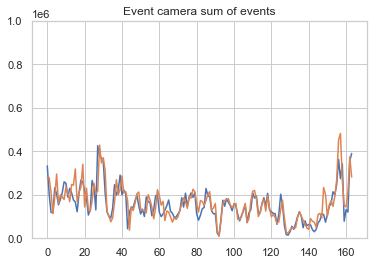

In [20]:
%matplotlib inline
plt.figure()
plt.title('Event camera sum of events')

for event_frame_total in event_frames_total_cropped:
    plt.plot(np.arange(len(event_frame_total)), event_frame_total.sum(axis=(1,2)))

plt.ylim(0, 1e6)
# plt.axvline(x=10, color='r', linestyle='-')
# plt.axvline(x=14, color='r', linestyle='-')

# plt.axvline(x=60, color='g', linestyle='-')
# plt.axvline(x=67, color='g', linestyle='-')

# plt.axvline(x=80, color='r', linestyle='-')
# plt.axvline(x=87, color='r', linestyle='-')

# plt.axvline(x=128, color='g', linestyle='-')
# plt.axvline(x=134, color='g', linestyle='-')

# plt.axvline(x=147, color='r', linestyle='-')
# plt.axvline(x=160, color='r', linestyle='-')

# plt.savefig('/home/tobias/traverses.png')

AxisError: axis 1 is out of bounds for array of dimension 1

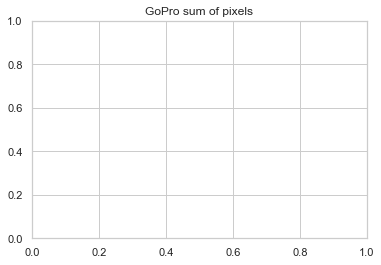

In [21]:
plt.figure()
plt.title('GoPro sum of pixels')
for gopro_frame in gopro_frames:
    plt.plot(np.arange(len(gopro_frame)), gopro_frame.sum(axis=(1,2)))
# plt.ylim(0, 350000)
# plt.savefig('/home/tobias/traverses.png')

In [22]:
event_means = [event_frame_total.mean(axis=0) for event_frame_total in event_frames_total_cropped]

In [23]:
gopro_means = [gopro_frame.mean(axis=0) for gopro_frame in gopro_frames]

C:\Users\ryanb\AppData\Local\Temp/ipykernel_20056/3817588041.py:1: RuntimeWarning: Mean of empty slice.
  gopro_means = [gopro_frame.mean(axis=0) for gopro_frame in gopro_frames]
C:\Users\ryanb\anaconda3\envs\EBS_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:title={'center':'Event camera mean of events'}>

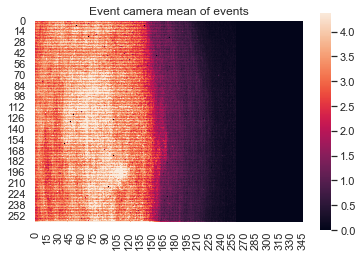

In [24]:
plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[0].T, robust=True, square=True, cbar=True)

In [25]:
# Find pixel that has most events
np.unravel_index(np.argmax(event_means[0]), event_means[0].shape)

(120, 259)

ValueError: Must pass 2-d input. shape=()

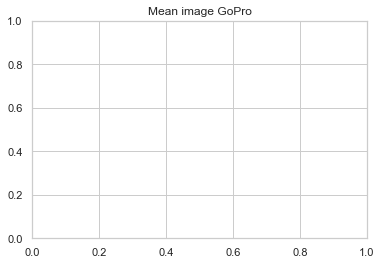

In [26]:
plt.figure()
plt.title('Mean image GoPro')
sns.heatmap(gopro_means[0], square=True, cbar=True, vmin=0, vmax=255, cmap='gray')

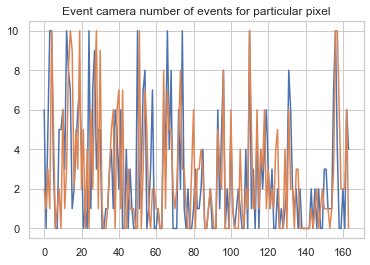

In [27]:
# Single pixel
plt.figure()
plt.title('Event camera number of events for particular pixel')

for event_frame_total in event_frames_total_cropped:
    plt.plot(np.arange(len(event_frame_total)), event_frame_total[:, 134, 28])

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

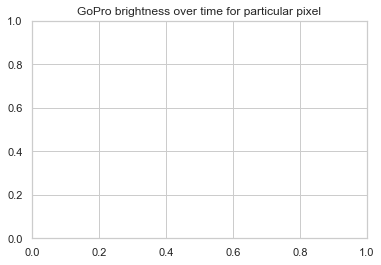

In [28]:
# Single pixel
plt.figure()
plt.title('GoPro brightness over time for particular pixel')


for gopro_frame in gopro_frames:
    plt.plot(np.arange(len(gopro_frame)), gopro_frame[:, 24, 24])
    plt.ylim(0, 255)

In [29]:
ref_traverse = 0
query_traverse = 1
dMat = cdist(event_frames_total_cropped[ref_traverse].reshape(event_frames_total_cropped[ref_traverse].shape[0], -1), event_frames_total_cropped[query_traverse].reshape(event_frames_total_cropped[query_traverse].shape[0], -1),'cityblock')

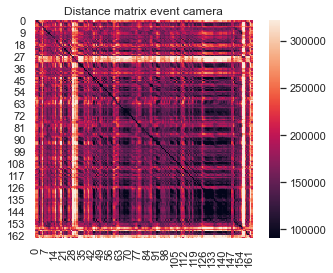

In [30]:
sns.heatmap(dMat, robust=True, square=True, cbar=True)
_ = plt.title('Distance matrix event camera')

In [31]:
dMat_gopro = cdist(gopro_frames[ref_traverse].reshape(gopro_frames[ref_traverse].shape[0], -1),gopro_frames[query_traverse].reshape(gopro_frames[query_traverse].shape[0], -1),'cityblock')

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [ ]:
sns.heatmap(dMat_gopro, robust=True, square=True, cbar=True)
_ = plt.title('Distance matrix GoPro')

In [32]:
prob_to_draw_from = np.copy(event_means[0])
# prob_to_draw_from[np.logical_and(prob_to_draw_from < 0.5, prob_to_draw_from != 0.0)] = 0.01

# Set low prob for "hot pixels"
prob_to_draw_from[prob_to_draw_from > (event_means[0].mean() + 2*event_means[0].std())] = 0.01
prob_sum = prob_to_draw_from.sum()
prob_to_draw_from = prob_to_draw_from / prob_sum

In [37]:
recall_dict = {}
used_pixels_dict = {}
use_saliency = True

seq_length = 15
maxLocRad = 4
gt_tolerance = maxLocRad
precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

num_trials = 15

num_target_pixels_list = [1, 2, 5, 10, 20, 50, 100, 150, 200, 250]
# num_target_pixels_list = [8]

for num_target_pixels in tqdm(num_target_pixels_list):
    if num_target_pixels in recall_dict:
        tqdm.write('skip')
        continue

    recall_dict[num_target_pixels] = []
    used_pixels_dict[num_target_pixels] = []

    for _ in range(num_trials):
        target_pixels = []
        while len(target_pixels) < num_target_pixels:
            random_idx_flat = np.random.choice(np.arange(0, im_height*im_width), p=prob_to_draw_from.reshape(-1) if use_saliency else None)
            random_pixel = np.unravel_index(random_idx_flat, (im_height, im_width))
            if len(target_pixels) == 0 or np.all(np.linalg.norm(np.array(target_pixels) - np.array(random_pixel), axis=1) > 3):
                target_pixels.append(random_pixel)

        # target_pixels_x = np.array([100, 100, 100, 100, 100, 100, 100, 100])
        # target_pixels_y = np.array([0,   25,  50,  75, 100, 125, 150, 175])
        # target_pixels = np.vstack((target_pixels_x, target_pixels_y)).T

        dist_matrices = []
        for target_pixel in target_pixels:
            count_traverse_ref = torch.from_numpy(event_frames_total_cropped[0][:, target_pixel[1], target_pixel[0]].astype(np.float32)).unsqueeze(0)
            count_traverse_qry = torch.from_numpy(event_frames_total_cropped[1][:, target_pixel[1], target_pixel[0]].astype(np.float32)).unsqueeze(0)
            dist_matrix_single = torch.abs(count_traverse_ref.unsqueeze(2) - count_traverse_qry.unsqueeze(1)).to('cpu').type(torch.FloatTensor).unsqueeze(0).squeeze(-1)
            dist_matrices.append(dist_matrix_single)

        dist_matrices_stacked = torch.stack(dist_matrices)
        dist_matrices_summed = torch.mean(dist_matrices_stacked, 0)
        seq_ret = seqSLAM_from_distMatGPU_multi_precomputed(dist_matrices_summed, precomputed_convWeight)
        dist_matrix_seqslam = torch.nn.functional.conv2d(dist_matrices_summed, precomputed_convWeight).squeeze()
        match_indices = seq_ret.indices.to('cpu').detach().numpy()
        match_scores = seq_ret.values.to('cpu').detach().numpy()
        # print(f'combined P@100R: {getPAt100R(match_indices, maxLocRad)[-1]:.2f}')

        prvals = getPRCurveWrapperFromScores(match_indices, match_scores, gt_tolerance)

        match_scores_revised = np.empty(match_scores.shape, dtype=np.float32)
        for query in range(len(dist_matrix_seqslam)):
            refs_sorted = dist_matrix_seqslam[query].argsort()
            best_match = refs_sorted[0]
            second_best_match = refs_sorted[torch.abs(refs_sorted - best_match) >= 3][0]
            match_scores_revised[query] = dist_matrix_seqslam[query][best_match] / dist_matrix_seqslam[query][second_best_match]

        prvals_revised = getPRCurveWrapperFromScores(match_indices, match_scores_revised, gt_tolerance)
        # tqdm.write(f'combined R@99P: {getRAtXPFromPRVals(prvals_revised, 0.99):.2f}')

        recall_dict[num_target_pixels].append(getRAtXPFromPRVals(prvals_revised, 0.99))
        used_pixels_dict[num_target_pixels].append(target_pixels)

    mean_recall = np.mean(recall_dict[num_target_pixels])
    median_recall = np.median(recall_dict[num_target_pixels])
    tqdm.write(f'mean R@99P: {mean_recall:.2f}; median R@99P: {median_recall:.2f}; worst R@99P: {np.array(recall_dict[num_target_pixels]).min():.2f}; best R@99P: {np.array(recall_dict[num_target_pixels]).max():.2f}')


  0%|          | 0/10 [00:00<?, ?it/s]

skip
skip
skip


NameError: name 'seqSLAM_from_distMatGPU_multi_precomputed' is not defined

In [ ]:
if use_saliency:
    recall_dict_sal = recall_dict
else:
    recall_dict_nosal = recall_dict

In [ ]:
import scipy.stats
scipy.stats.ttest_ind(recall_dict_sal[10], recall_dict_nosal[10])

In [ ]:
fig, axs = plt.subplots(len(num_target_pixels_list), 2, figsize=(18, len(num_target_pixels_list)*8))

for idx, num_target_pixels in enumerate(num_target_pixels_list):
    best_recall, worst_recall = 0.0, 1.0
    best_recall_idx, worst_recall_idx = 0, 0
    for j in range(num_trials):
        recall = np.mean(recall_dict[num_target_pixels][j])
        if recall > best_recall:
            best_recall = recall
            best_recall_idx = j
        if recall < worst_recall:
            worst_recall = recall
            worst_recall_idx = j

    axs[idx, 0].imshow(event_means[0])
    for px in used_pixels_dict[num_target_pixels][best_recall_idx]:
        axs[idx, 0].set_title(f'{num_target_pixels} pixels, best R@99P: {best_recall:.2f}')
        axs[idx, 0].add_patch(Circle((px[1], px[0]), 3))

    axs[idx, 1].imshow(event_means[0])
    for px in used_pixels_dict[num_target_pixels][worst_recall_idx]:
        axs[idx, 1].set_title(f'{num_target_pixels} pixels, worst R@99P: {worst_recall:.2f}')
        axs[idx, 1].add_patch(Circle((px[1], px[0]), 3))


In [ ]:
fig = plt.figure()
plt.title('R@99P comparison salient vs random pixels')

x = np.array([val for val in num_target_pixels_list for _ in range(num_trials)] + [val for val in num_target_pixels_list for _ in range(num_trials)])
y = np.vstack((np.array(list(recall_dict_sal.values())), np.array(list(recall_dict_nosal.values())))).flatten()
hue = ["salient"]*len(num_target_pixels_list)*num_trials + ["random"]*len(num_target_pixels_list)*num_trials

sns.boxplot(x=x,
               y=y,
               hue=hue)

plt.legend()

plt.savefig('/home/tobias/salient-vs-random-pixels.png')
plt.show()

In [ ]:
display_timestep = 1.0 / 30.0
history_time = 1.0 / 30.0

display_timestep_ms = int(display_timestep * 10e5)
history_time_ms = int(history_time * 10e5)

In [ ]:
event_stream_numpy = event_streams_numpy[0]

target_times = np.arange(event_stream_numpy[0, t_index] + history_time_ms, event_stream_numpy[-1, t_index], display_timestep_ms, dtype=np.uint64)

# plt.figure(1)

def get_start_end_indices(target_time_idx):
    target_time = target_times[target_time_idx]

    start_time = np.uint64(target_time - history_time_ms)
    end_time = np.uint64(target_time)

    start_idx = event_stream_numpy[:, t_index].searchsorted(start_time)
    end_idx = event_stream_numpy[:, t_index].searchsorted(end_time)

    return start_idx, end_idx

def f(target_time_idx):
    measure_time_start = time.perf_counter()
    start_idx, end_idx = get_start_end_indices(target_time_idx)
    target_time = target_times[target_time_idx]

    out_image = np.ones((im_height, im_width, 3), dtype=np.uint8) * 255
    events = event_stream_numpy[start_idx:end_idx]
    for t, x, y, p in events:
        out_image[y, x] = (0, 0, 255) if p == 0 else (255, 0, 0)

    text_to_print = f"idx: {target_time_idx}; t: {target_time / 10e5: .2f}; len: {len(events)}"
    cv2.putText(out_image, text_to_print, (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0))

    mediapy.show_image(out_image)

def g(target_time_idx):
    start_idx, end_idx = get_start_end_indices(target_time_idx)
    events = event_stream_numpy[start_idx:end_idx]
    events = events.squeeze()
    volume = transform(events, sensor_size=sensor_size, ordering=ordering)
    mediapy.show_image(volume[0, :, :])


play = widgets.Play(
    value=0,
    min=0,
    max=len(target_times),
    step=1,
    interval=display_timestep * 1000,
    description="Press play",
    disabled=False
)
slider = widgets.IntSlider(max=len(target_times))
widgets.jslink((play, 'value'), (slider, 'value'))
# widgets.HBox([play, slider])

interactive_plot = interactive(f, target_time_idx=play)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot
display(widgets.VBox([slider, interactive_plot]))

In [ ]:
transform = transforms.Compose(
    [transforms.ToVoxelGrid(n_time_bins=1)]
)
events = np.copy(event_stream_numpy[start_idx:end_idx])
events = events.squeeze()
volume = transform(events, sensor_size=sensor_size, ordering=ordering)
mediapy.show_image(volume[0, :, :], cmap='viridis')